In [80]:
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [81]:
path = 'ptb-xl/'
sampling_rate = 500

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

In [82]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [83]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [84]:
def load_raw_data(df, path):
    data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    data = np.array([signal for signal, meta in data])
    return data

X = load_raw_data(Y, path)

In [85]:
X.shape

(21837, 1000, 12)

In [86]:
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [87]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

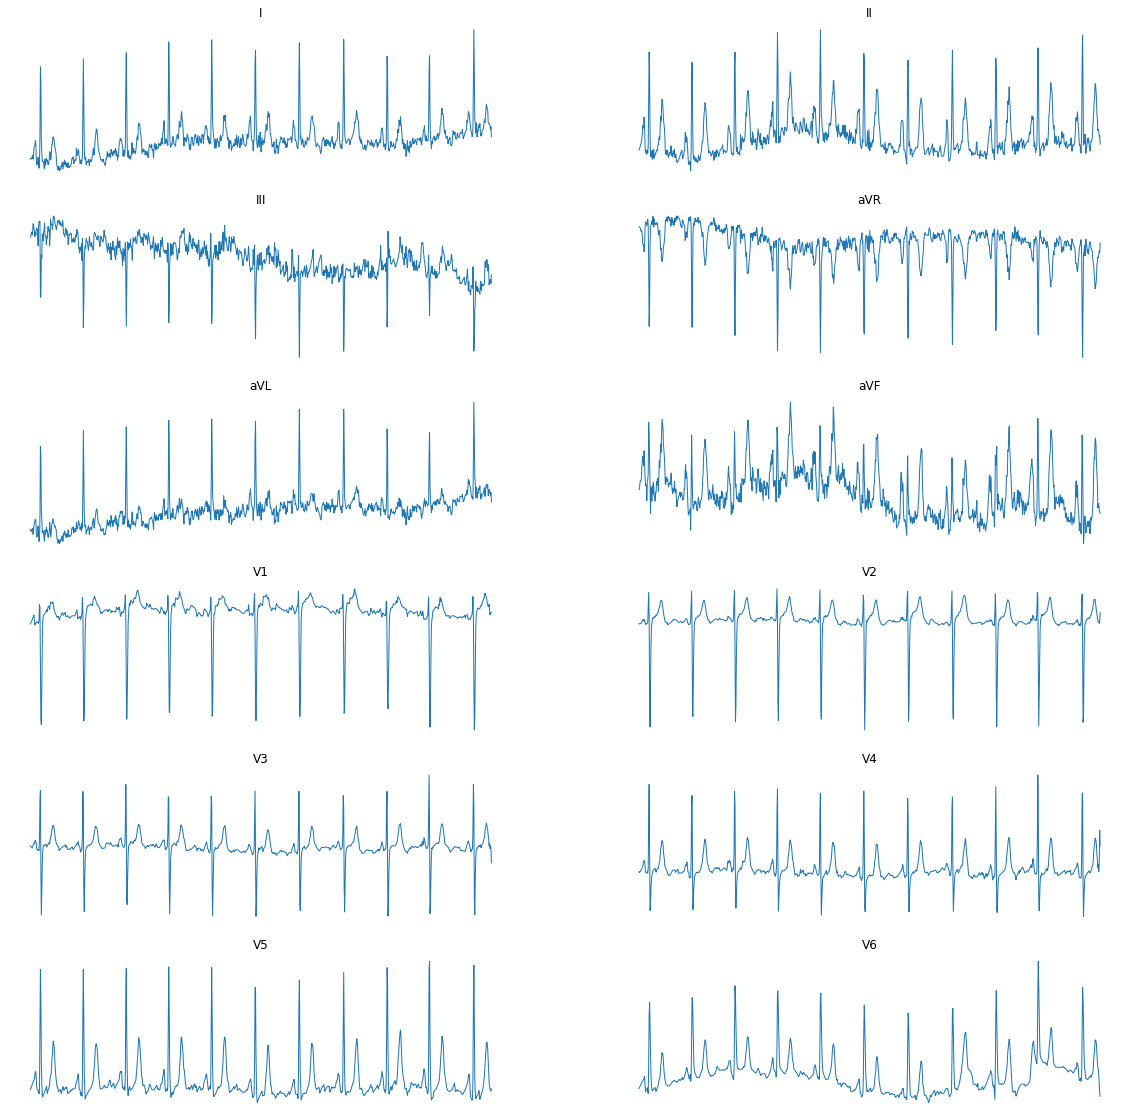

In [88]:
ecg = X[0]
titles = ["I", "II", "III", "aVR", "aVL", "aVF",
          "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(12):
    plt.subplot(6,2,index+1)
    plt.plot(ecg[:,index], linewidth=1)
    
    plt.gca()
    plt.title(titles[index])
    plt.axis('off')

plt.show()

In [89]:
def smoothing(a, n, mode="same"):
    return(np.convolve(a, np.ones((n,)) / n, mode=mode))


ecg_original = X[0][:,0]
ecg_filtered = smoothing(ecg_original, 5)

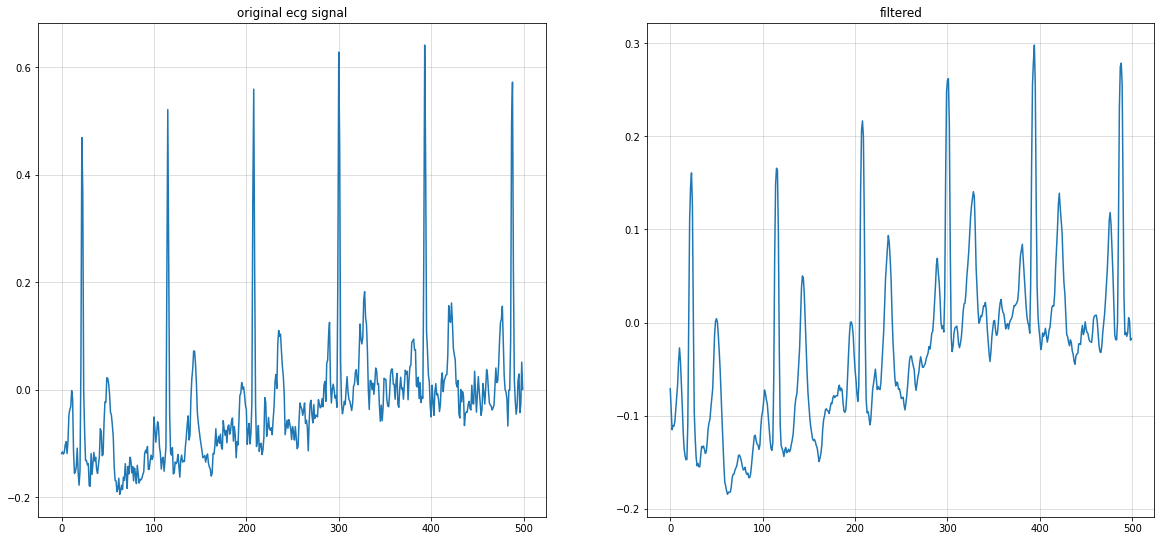

In [90]:
def show_diff(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.show()


show_diff(ecg_original, ecg_filtered, 'original ecg signal', 'filtered')

In [92]:
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = smoothing(X[index][:, channel], 5)

In [93]:
ecg_rhythms = X

0

In [94]:
# Split data into train and test
test_fold = 10
# Train
X_train = ecg_rhythms[(Y.strat_fold != test_fold) & (Y.Runconfirmed != 1)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = ecg_rhythms[(Y.strat_fold == test_fold) & (Y.Runconfirmed != 1)]
y_test = Y[(Y.strat_fold == test_fold)].diagnostic_superclass

In [95]:
save_path = 'data/'
np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

In [96]:
data_filepath = "data/"

X_train = np.load(data_filepath + 'X_train.npy')
y_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
X_test = np.load(data_filepath + 'X_test.npy')
y_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)

# reshape y_train, y_test
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [97]:
def shuffle_train_test(X_train, y_train, X_test, y_test):
    shuffled_indices_x = np.random.permutation(len(y_train))
    shuffled_indices_y = np.random.permutation(len(y_test))

    return X_train[shuffled_indices_x], y_train[shuffled_indices_x], X_test[shuffled_indices_y], y_test[shuffled_indices_y]

X_train, y_train, X_test, y_test = shuffle_train_test(X_train, y_train, X_test, y_test)


In [98]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])
np.where(num2class == 'STTC')[0][0]

2

In [99]:
for index in range(len(y_train)):
    if len(y_train[index][0]) == 0:
        y_train[index] = 0
    else:
        y_train[index] = np.where(num2class == y_train[index][0][0])[0]

In [100]:
y_train

array([[1],
       [0],
       [3],
       ...,
       [0],
       [4],
       [0]], dtype=object)

In [101]:
for index in range(len(y_test)):
    if len(y_test[index][0]) == 0:
        y_test[index] = 0
    else:
        y_test[index] = np.where(num2class == y_test[index][0][0])[0]

In [102]:
y_train = y_train.reshape(1, -1)[0].astype('uint8')
y_test = y_test.reshape(1, -1)[0].astype('uint8')
y_train

array([1, 0, 3, ..., 0, 4, 0], dtype=uint8)

Балансировка классов:

In [104]:
oversampler = SMOTE(random_state=42)
os_features, os_label = oversampler.fit_resample(X_train.reshape(len(X_train), 12000), y_train)

Метод главных компонент:

In [106]:
pca_train = PCA(n_components=240)
pca_train.fit(os_features)

PCA(n_components=240)

In [107]:
X_train_pca = pca_train.fit_transform(os_features)
pca_train.explained_variance_ratio_.sum()

0.7254892300500182

In [109]:
X_test_flatten = X_test.reshape(len(X_test), 12000)
pca_test = PCA(n_components=240)
pca_test = PCA(X_test_flatten)

In [110]:
X_test_pca = pca_train.fit_transform(X_test_flatten)

In [112]:
train_class = 3
print("train class is %s-"%(num2class[train_class]))
y_train_norm = (os_label == train_class)
y_test_norm = (y_test == train_class)

train class is CD-


Стохастический градиентный спуск:

In [113]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_pca, y_train_norm)

SGDClassifier(random_state=42)

In [114]:
y_predict_sgd = sgd_clf.predict(X_test_pca)
y_predict_sgd[0:10]

array([False, False, False, False, False,  True, False, False, False,
        True])

In [116]:
def k_fold_val(classifier, k_fold=5):
    skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    fold = 1
    total_accu = 0
    for train_index, test_index in skfolds.split(X_train_pca, y_train_norm):
        clone_clf = clone(classifier)
        X_train_folds = X_train_pca[train_index]
        y_train_folds = y_train_norm[train_index]
        X_test_fold = X_train_pca[test_index]
        y_test_fold = y_train_norm[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        fold += 1
        total_accu += n_correct / len(y_pred)
    print("\nTotal Accuracy: %f" % (total_accu/k_fold))

k_fold_val(sgd_clf)


Total Accuracy: 0.789973


In [117]:
cross_val_score(sgd_clf, X_train_pca, y_train_norm, cv=5, scoring="accuracy")

array([0.77978212, 0.78950451, 0.79618133, 0.79758697, 0.78458475])

In [119]:
y_scores_sgd = cross_val_predict(sgd_clf, X_train_pca, y_train_norm, cv=5, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_norm, y_scores_sgd)

In [120]:
roc_auc_score(y_train_norm, y_scores_sgd)

0.5340418865058162

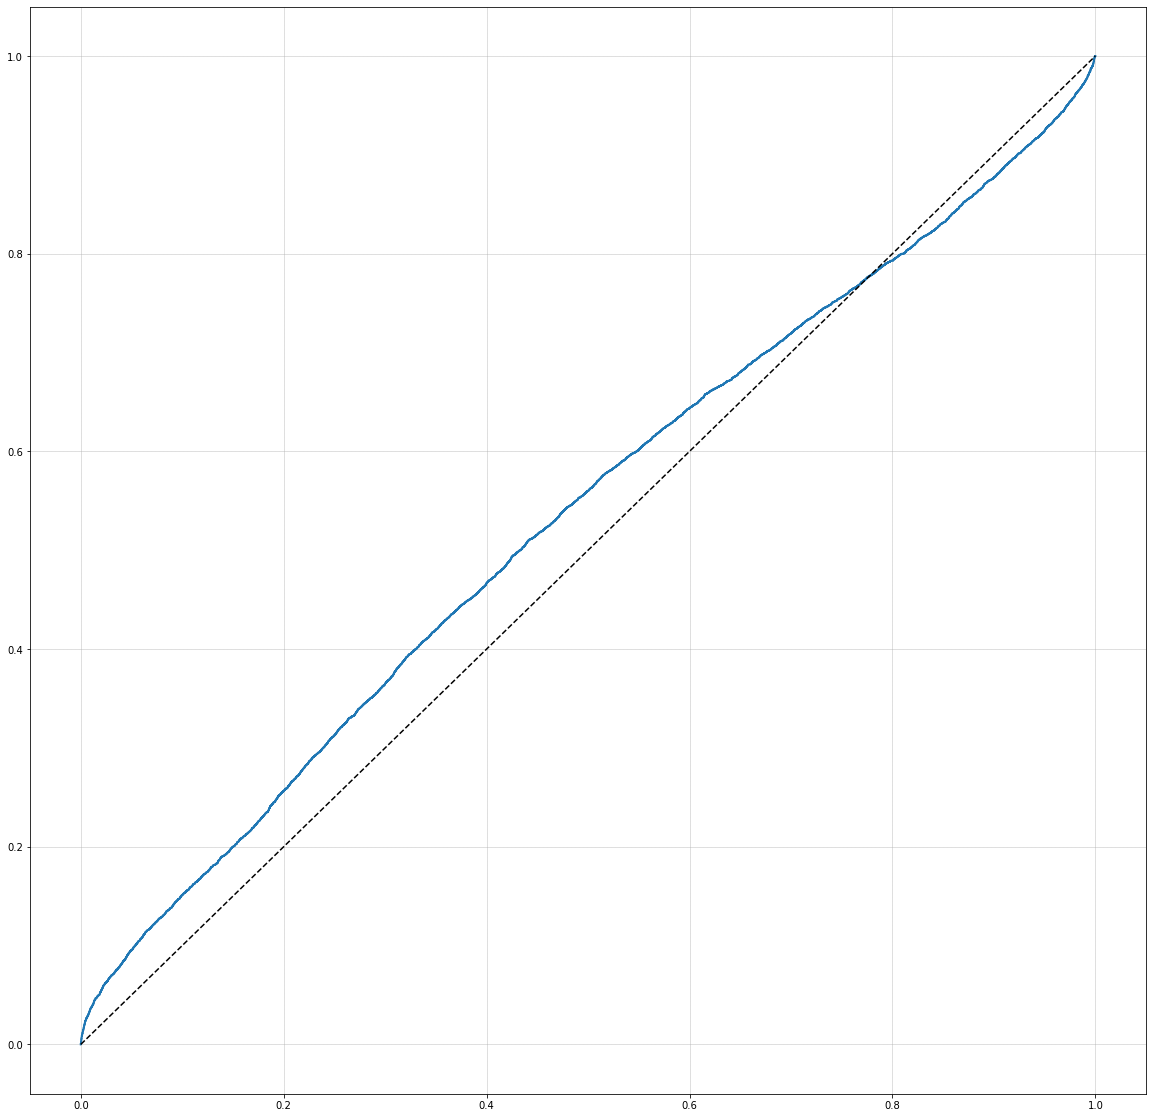

In [121]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [122]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_pca, y_train_norm, cv=5 ,method="predict_proba")

In [123]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_norm, y_scores_forest)

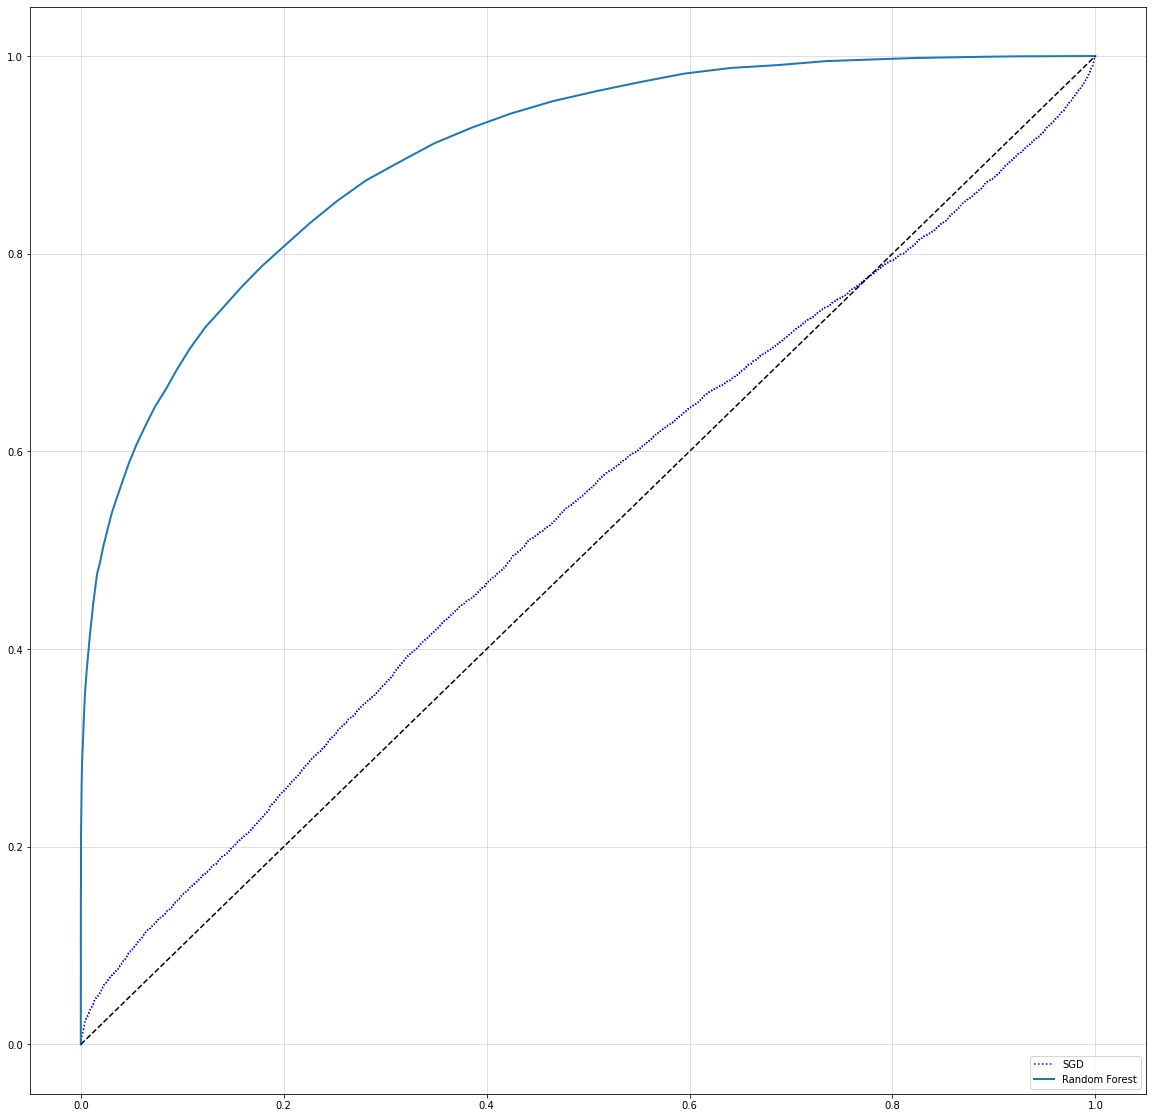

In [124]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [125]:
roc_auc_score(y_train_norm, y_scores_forest)

0.8988272754217257

In [127]:
y_train_pred = (y_scores_forest >= 0.5)

In [128]:
confusion_matrix(y_train_norm, y_train_pred)

array([[33919,   229],
       [ 5218,  3319]], dtype=int64)

In [129]:
precision_score(y_train_norm, y_train_pred)

0.935456595264938

In [132]:
y_scores_forest_all = []
for train_class in range(1,5):
    print("Classifier for %s:" % (num2class[train_class]))
    y_train_norm = (os_label == train_class)

    forest_clf = RandomForestClassifier(random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train_pca, y_train_norm, cv=5 ,method="predict_proba")
    y_scores_forest = y_probas_forest[:, 1]
    y_train_pred = (y_scores_forest>=0.5)
    y_scores_forest_all.append(y_scores_forest)

    print("accuracy: %.3f" % np.mean(cross_val_score(forest_clf, X_train_pca, y_train_norm, cv=5, scoring="accuracy")))
    print("precision: %.3f" % precision_score(y_train_norm, y_train_pred))
    print("roc score: %.3f" % roc_auc_score(y_train_norm, y_scores_forest))

Classifier for MI:
accuracy: 0.896
precision: 0.991
roc score: 0.952
Classifier for STTC:
accuracy: 0.905
precision: 0.996
roc score: 0.970
Classifier for CD:
accuracy: 0.871
precision: 0.935
roc score: 0.899
Classifier for HYP:
accuracy: 0.920
precision: 0.986
roc score: 0.964
